# Análisis de datos reales multidimensionales - India 

## Funciones

In [7]:
# Función para leer los datasets

def file_reader(filename, dataset):
    with tb.open_file(filename) as f:
        child = f.root
        for element in dataset.split('/'):
            child = child.__getattr__(element)
        return child[:]

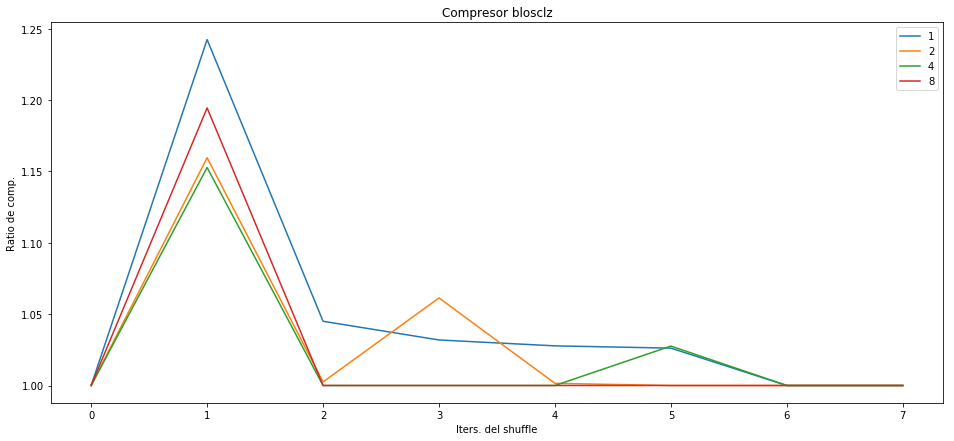

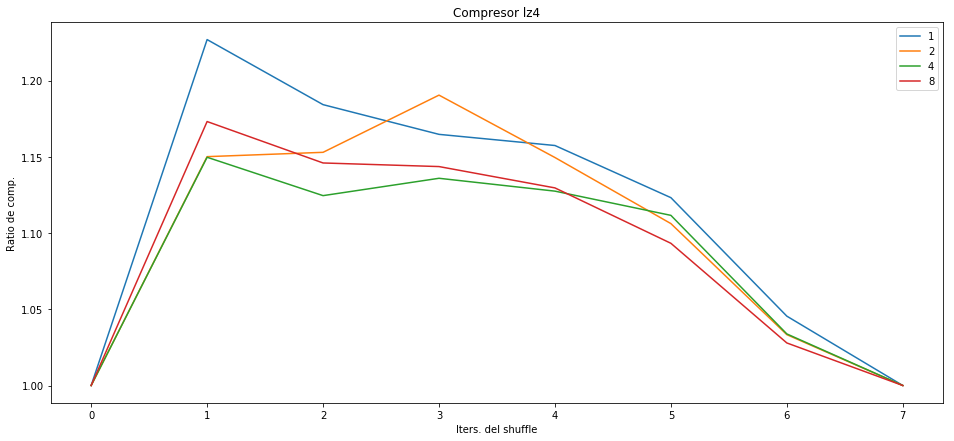

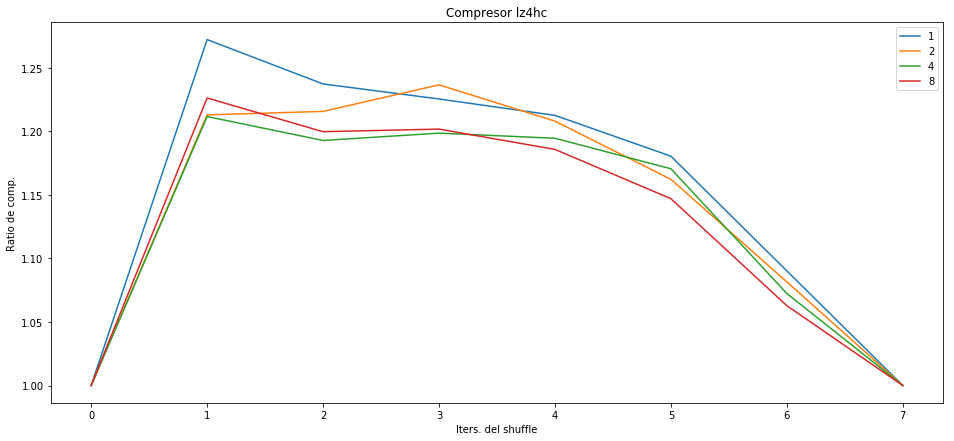

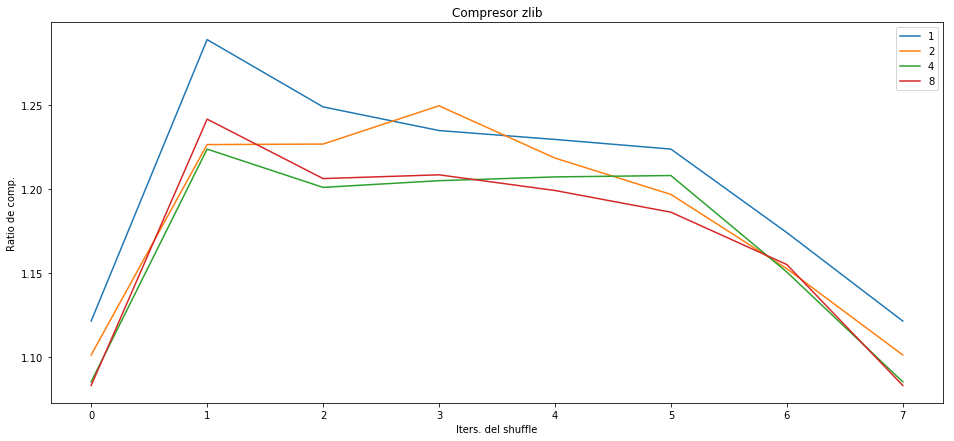

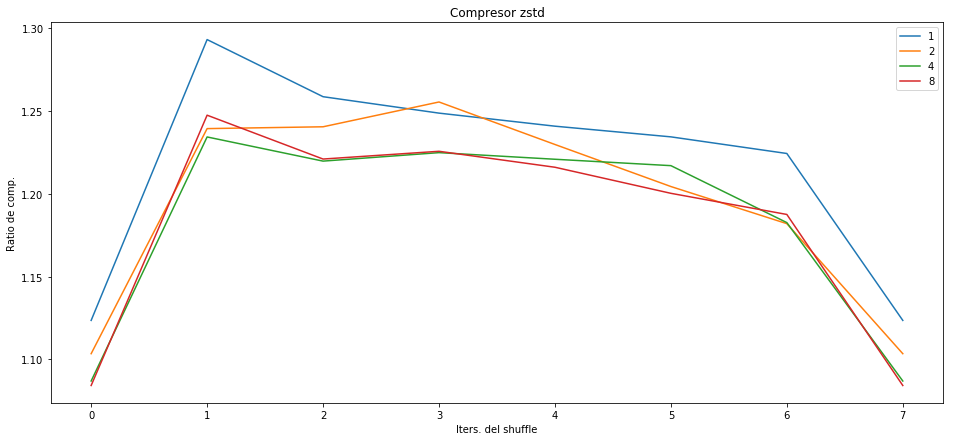

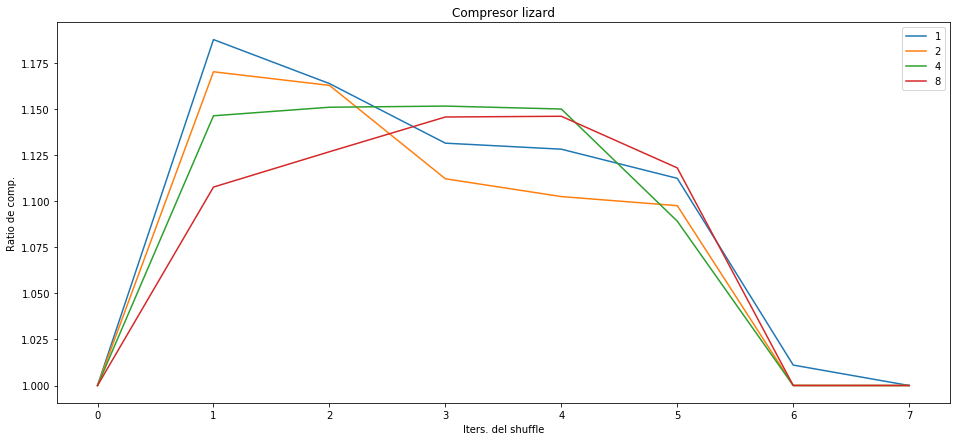

In [33]:
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import pycblosc2 as cb2
import numpy as np
from math import log
import time as t


    
# Definición de los parámetros de blosc
    
KB = 1024
MB = 1024 * KB
GB = 1024 * MB

BLOSC_MAX_FILTERS = 5
BLOSC_BLOCKSIZE = 16 * KB

cparams = cb2.blosc2_create_cparams(compcode=1, clevel=5, use_dict=0, typesize=4,
                                    nthreads=4, blocksize= BLOSC_BLOCKSIZE, schunk=None,
                                    filters=[0, 0, 0, 0, 1],
                                    filters_meta=[0, 0, 0, 0, 2])

dparams = cb2.blosc2_create_dparams(nthreads=1, schunk=None)
# Lectura del dataset

PATH = '/home/aleix/datasets/'

filename = 'WRF_India.h5'

dataset = 'U'

data = file_reader(PATH + filename, dataset)

data = np.resize(data, (2**9, 2**5, 2**4, 2**7))

div = 2 ** np.arange(4 + 1)

x = len(data)
y = len(data[0])
z = len(data[0][0])
w = len(data[0][0][0])

isize = data.size * data.dtype.itemsize

dsize = 0

# Cálculo del orden de la permutación

TAM_DATA = data.dtype.itemsize

DATA_SIZE = BLOSC_BLOCKSIZE/TAM_DATA


if  log(DATA_SIZE, 2) % log(TAM_DATA, 2) == 0:
    orden = int(log(DATA_SIZE, TAM_DATA) + 1)
else:
    orden = int(log(DATA_SIZE, 2) + log(TAM_DATA, 2))

# Cálculo de los ratios de compresión

for code in [0, 1, 2, 4, 5, 6]:

    cparams.compcode = code   
    
    fig = plt.figure(figsize=(16, 7))
      
    n = []
    ratio = []
    speed = []

    cparams.filters[BLOSC_MAX_FILTERS - 1] = 0

    start = t.perf_counter()
    
    s_data = data.flatten()

    end = t.perf_counter()
    
    t_trans = end - start

    start = t.perf_counter()

    schunk = cb2.blosc2_new_schunk(cparams, dparams)
    nchunks = cb2.blosc2_append_buffer(schunk, isize, s_data)
    nbytes = schunk.nbytes
    cbytes = schunk.cbytes

    cb2.blosc2_free_schunk(schunk)

    end = t.perf_counter()

    ttotal = (end - start) + t_trans

    r = (1. * nbytes) / cbytes
    s = nbytes / (ttotal * MB)
    n.append(0)
    
    ratio.append(r)
    speed.append(s)

    cparams.filters[BLOSC_MAX_FILTERS - 1] = 1

    for i_iter in range(orden):

        cparams.filters_meta[BLOSC_MAX_FILTERS - 1] = i_iter

        start = t.perf_counter()

        schunk = cb2.blosc2_new_schunk(cparams, dparams)
        nchunks = cb2.blosc2_append_buffer(schunk, isize, s_data)
        nbytes = schunk.nbytes
        cbytes = schunk.cbytes

        cb2.blosc2_free_schunk(schunk)

        end = t.perf_counter()

        ttotal = (end - start) + t_trans

        r = (1. * nbytes) / cbytes
        s = nbytes / (ttotal * MB)
        n.append(i_iter + 1)
        ratio.append(r)
        speed.append(s)

        #print('Time: {0:.4f} secs.'.format(ttotal))
        #print('Ratio: {0:.6f}'.format(r))
        #print('Speed: {0:4f}'.format(s))

    plt.plot(n, ratio, label = cb2.blosc_compcode_to_compname(code)[1])
    
    plt.ylabel("Tasa de comp.")
    plt.xlabel("Iters. del shuffle")
    plt.title("Análisis del shuffle iterativo")
    plt.legend(loc = "upper right")
    plt.show()